In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

pd.set_option("display.max_column", 999)


# Data prep
tourney_results = pd.read_csv('C:/Users/Bryan/Desktop/2023 March Madness Prediction Project/Data/WNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('C:/Users/Bryan/Desktop/2023 March Madness Prediction Project/Data/WNCAATourneySeeds.csv')
regular_results = pd.read_csv('C:/Users/Bryan/Desktop/2023 March Madness Prediction Project/Data/WRegularSeasonDetailedResults.csv')

regular_results['WEFFG'] = regular_results['WFGM'] / regular_results['WFGA']
regular_results['WEFFG3'] = regular_results['WFGM3'] / regular_results['WFGA3']
regular_results['WDARE'] = regular_results['WFGM3'] / regular_results['WFGM']
regular_results['WTOQUETOQUE'] = regular_results['WAst'] / regular_results['WFGM']

regular_results['LEFFG'] = regular_results['LFGM'] / regular_results['LFGA']
regular_results['LEFFG3'] = regular_results['LFGM3'] / regular_results['LFGA3']
regular_results['LDARE'] = regular_results['LFGM3'] / regular_results['LFGM']
regular_results['LTOQUETOQUE'] = regular_results['LAst'] / regular_results['LFGM']

In [2]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)


In [3]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff', 'T1_EFFG', 'T1_EFFG3', 'T1_DARE', 'T1_TOQUETOQUE', 'T2_EFFG', 'T2_EFFG3', 'T2_DARE', 'T2_TOQUETOQUE']
# Choose a function to aggregate
funcs = [np.mean]


season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

# #Make two copies of the data
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape


def normalize_column(values):
  themean = np.mean(values)
  thestd = np.std(values)
  norm = (values - themean)/(thestd) 
  return(pd.DataFrame(norm))

def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = normalize_column(quality['quality'])
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    print(quality['quality'].mean(), quality['quality'].std())
    return quality

In [4]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         team_quality(2021),
                         team_quality(2022)]).reset_index(drop=True)

glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']



tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

0.996232709118413 0.9690510917618073
0.8204741108737932 0.3758754360418743


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2.5394182206688543 2.3846286259231846
2.6020827422808193 1.245526243326036
2.4797954747896607 1.3310132058094677
2.6653932474133217 0.6760408518464364
2.699921342310161 0.5907782887887418
2.5916749110255854 1.1200686248133944
2.570781282267534 1.0827952210282727
2.656349880229653 0.7684661455902141


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.150844238934035 1.212038400741575
0.7982804005633402 0.32608636784952943


Fold repeater 0
[12:19:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[12:19:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[12:19:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[12:19:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[12:19:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	

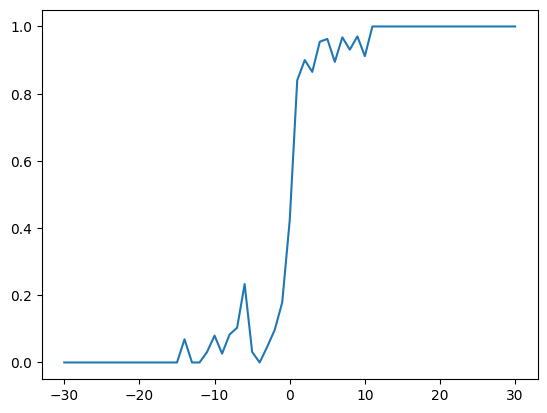

In [5]:
tourney_data['T1_quality'].fillna(0.2, inplace = True)
tourney_data['T2_quality'].fillna(0.2, inplace = True)
tourney_data.T2_quality.isnull().sum()

seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

#Optional but not relevant
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

# Time to build some models!

# # The descriptive feature is the score, not the winner
y = tourney_data['T1_Score'] - tourney_data['T2_Score']

features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

features

X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.02 #recommend change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10 #recommend 10 (this is very important for kagglers)
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

xgb_cv = []
repeat_cv = 2 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 1000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )
    iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]

#This is to get out-of-fold predictions
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
    preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)

sub = pd.read_csv('C:/Users/Bryan/Desktop/2023 March Madness Prediction Project/Data/SampleSubmission2023.csv')
sub.shape

sub["Season"] = sub["ID"].apply(lambda x: x[0:4]).astype(int)
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.shape

sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'])
print(sub.shape)
sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left') # This is because some teams didn't face off in the regular season
sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
print(sub.shape)
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'])
print(sub.shape)
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]
sub.shape

print(sub.T2_quality.isnull().sum())
sub['T1_quality'].fillna(0.2, inplace = True)
sub['T2_quality'].fillna(0.2, inplace = True)
sub.T2_quality.isnull().sum()

Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )
sub_preds = []
for i in range(repeat_cv):
    subm = sub_models[i].predict(dtest)
    sub_preds.append(np.clip(spline_model[i](np.clip(subm,-30,30)),0.025,0.975))
sub['Pred'] = pd.DataFrame(sub_preds).mean(axis = 0)

print(sub['Pred'].mean())

full_sub = pd.read_csv('C:/Users/Bryan/Desktop/2023 March Madness Prediction Project/Data/SampleSubmission2023.csv')
full_sub.columns = ['ID', 'ignore']

full_sub = pd.merge(full_sub, sub[['ID', 'Pred']], on =  'ID', how = 'left')
# full_sub.fillna(0.5, inplace = True)
full_sub.drop(['ignore'], axis = 1, inplace = True)
full_sub.to_csv("tes.csv", index = None)
